### NOTE: This notebook only includes atomic-cooling galaxies with PopII stars. Pop III stars in minihalos have not been added to this module yet.

This tutorial will cover how to generate UVLFs from Zeus21. It is recommended to do the basics tutorial first, to get a handle on how the code works. That said, this can stand on its own, so let's go!

In [1]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
import copy


#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

---------------------------------------
SL: imported standard CLASS
---------------------------------------


Now we set up the cosmology and astrophysics. We do not need to go as far as the 21-cm calculation when doing UVLFs. We do not need the Coeff or PS21 structures (since we won't compute 21-cm in this tutorial), nor do we need the correlation functions. We do need the HMFs, though.

As before, we begin by running CLASS, where you can change the input parameters as shown below. Then we save the cosmo parameters, the correlation functions, and the halo mass function at all desired z and M. T

Then we set up the astro parameters. They're shared between the UVLF and the 21-cm calculation so one can jointly do inference.

In [3]:
CosmoParams_input = zeus21.Cosmo_Parameters_Input(zmin_CLASS=0.0) #make sure to provide zmin_CLASS lower than standard (5.0) if you want lower z results (eg HMFs)

CosmoParams,ClassyCosmo, CorrFclass ,HMFintclass =  zeus21.cosmo_wrapper(CosmoParams_input)

Now we have to define the astrophysical parameters. You can run with the default set, but let's spice things up a bit. Let's define two:
-One with a standard halo-galaxy connection
-One with a very stochastic halo-galaxy connection, but lower UV brightness per galaxy (smaller f* at peak)

In [4]:
AstroParams_std = zeus21.Astro_Parameters(CosmoParams, accretion_model=0) #made accretion_model exponential, like in the paper (2306.09403)
AstroParams_bursty = zeus21.Astro_Parameters(CosmoParams, sigmaUV=0.9, accretion_model=0) #made accretion_model exponential, like in the paper (2306.09403)

Now define the redshift and magnitudes over which to plot. You give an arbitrary <z> and width dz, and the code will assume the selection function is a Gaussian around it. For magnitudes you provide centers and widths of bins, assumed to be tophats. It will then generate the UVLF under those specs. Make sure the binning of z and MUV are the same as whatever date you're considering!

In [5]:
z, dz = 5.0, 0.5 #zcentral and width (assumed Gaussian)

MUVcenters = np.linspace(-17,-23,13) #centers of bins
MUVwidths = -np.diff(MUVcenters)
MUVwidths = np.append(MUVwidths,MUVwidths[-1])

/mnt/DATA/programs/anaconda3/envs/zeus21/lib/python3.9/site-packages/zeus21/UVLFs.py:29: RuntimeWarning: divide by zero encountered in log10
  MUVtab = 51.63 - 2.5 * np.log10(LUVtab) #AB magnitude


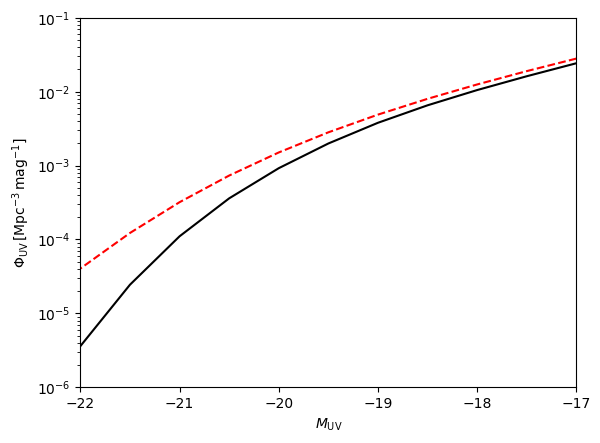

In [6]:
UVLFs_std = zeus21.UVLFs.UVLF_binned(AstroParams_std,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths)
UVLFs_bursty = zeus21.UVLFs.UVLF_binned(AstroParams_bursty,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths)


plt.semilogy(MUVcenters,UVLFs_std,'k-')
plt.semilogy(MUVcenters,UVLFs_bursty,'r--')
plt.xlim(-22,-17)
plt.ylim(1e-6,1e-1)
plt.xlabel(r'$M_{\rm UV}$');
plt.ylabel(r'$\Phi_{\rm UV}\,\rm [Mpc^{-3}\,mag^{-1}]$');

If you're new to the world of UVLFs note that the x axis is a UV absolute magnitude, and y is the comoving number density of galaxies at that magnitude (divided by the width of the bin)

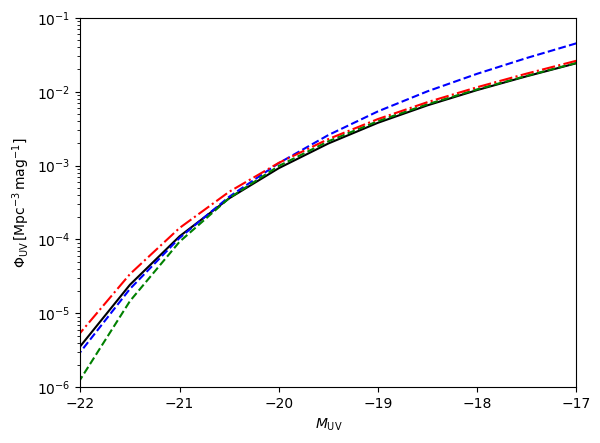

In [7]:
#now let's change the alpha and beta too to see what they do
AstroParams_lowalpha = copy.deepcopy(AstroParams_std)
AstroParams_lowalpha.alphastar-=0.2
UVLFs_lowalpha = zeus21.UVLFs.UVLF_binned(AstroParams_lowalpha,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths)

AstroParams_lowbeta = copy.deepcopy(AstroParams_std)
AstroParams_lowbeta.betastar-=0.2
UVLFs_lowbeta = zeus21.UVLFs.UVLF_binned(AstroParams_lowbeta,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths)

#and the dust assumptions -- they can be degenerate! (Beware, these are measured independently, see Refs.)
AstroParams_lessdust = copy.deepcopy(AstroParams_std)
AstroParams_lessdust.C0dust-=0.1;
UVLFs_lessdust = zeus21.UVLFs.UVLF_binned(AstroParams_lessdust,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths)


plt.semilogy(MUVcenters,UVLFs_std,'k-')
plt.semilogy(MUVcenters,UVLFs_lowalpha,'b--')
plt.semilogy(MUVcenters,UVLFs_lowbeta,'g--')
plt.semilogy(MUVcenters,UVLFs_lessdust,'r-.')
plt.xlim(-22,-17)
plt.ylim(1e-6,1e-1)
plt.xlabel(r'$M_{\rm UV}$');
plt.ylabel(r'$\Phi_{\rm UV}\,\rm [Mpc^{-3}\,mag^{-1}]$');


Zeus allows to compute the bias as a function of MUV as well. Let's do that and plot it!

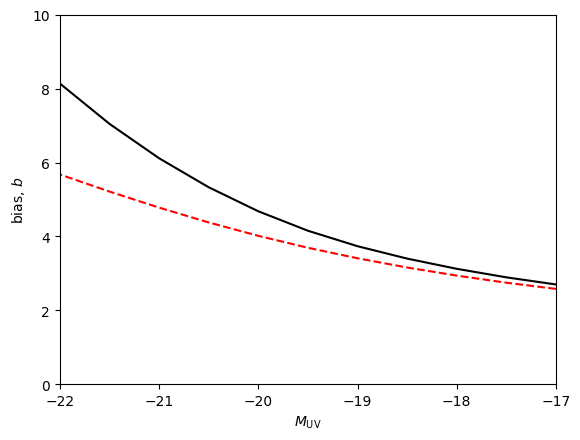

In [8]:

bias_UVLFs_std = zeus21.UVLFs.UVLF_binned(AstroParams_std,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths,RETURNBIAS=True)/UVLFs_std
bias_UVLFs_bursty = zeus21.UVLFs.UVLF_binned(AstroParams_bursty,CosmoParams,HMFintclass,z,dz,MUVcenters,MUVwidths,RETURNBIAS=True)/UVLFs_bursty
#note it's divided by UVLF, since the bias returns <b>*Phi on each MUV bin, so you have to divide by UVLF to get the bias alone

plt.plot(MUVcenters,bias_UVLFs_std,'k-')
plt.plot(MUVcenters,bias_UVLFs_bursty,'r--')
plt.xlim(-22,-17)
plt.ylim(0,10)
plt.xlabel(r'$M_{\rm UV}$');
plt.ylabel(r'bias, $b$');

Note a possible issue: for no/low stochasticity (sigmaUV~0) the UVLF becomes noisy because there are not enough halos in each MUV bin. Can be fixed change precisionboost in constants.py